# Predicting Stock Prices Using Insider Data

## 1 Preprocessing Both Datasets

In [49]:
import pandas as pd

insider_data = pd.read_csv('CSCO_insider_data.csv')
stock_data = pd.read_csv('CSCO_stock_data.csv')

In [50]:
insider_data = insider_data.drop(columns=['company_name', 'ticker', 'insider_name', 'job_title'])

In [51]:
insider_data['trade_type'] = insider_data['trade_type'].replace({'S': 1, 'P': 0})

/var/folders/v_/3rfld4fn7s14pz1_cmd8q_580000gn/T/ipykernel_17709/1854117035.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  insider_data['trade_type'] = insider_data['trade_type'].replace({'S': 1, 'P': 0})


In [52]:
# insider_data['filing_date'] = pd.to_datetime(insider_data['filing_date'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None)

In [53]:
print(insider_data.shape)
print(stock_data.shape)

(1714, 7)
(4716, 6)


In [54]:
insider_data

,filing_date,trade_type,price,quantity_traded,final_shares_owned,change_in_shares_owned,value_of_shares_traded
0,2006-01-04,1,17.19,-7333.0,2789.0,-262.925780,-126054.27
1,2006-01-04,1,17.19,-7291.0,2789.0,-261.419864,-125332.29
2,2006-01-04,1,17.19,-7291.0,2789.0,-261.419864,-125332.29
3,2006-01-06,1,18.50,-30000.0,2789.0,-1075.654356,-555000.00
4,2006-02-10,1,19.95,-45000.0,82764.0,-54.371466,-897750.00
...,...,...,...,...,...,...,...
1709,2024-08-22,1,50.33,-8270.0,135544.0,-6.101340,-416229.10
1710,2024-08-28,1,50.36,-3379.0,47182.0,-7.161629,-170166.44
1711,2024-09-12,1,49.09,-638.0,46017.0,-1.386444,-31319.42
1712,2024-09-12,1,48.92,-1328.0,132910.0,-0.999172,-64965.76


In [55]:
stock_data

,Date,Open,High,Low,Close,Volume
0,2006-01-03 05:00:00,11.484047,11.670888,11.464029,11.644197,55426000
1,2006-01-04 05:00:00,11.664215,11.964496,11.650869,11.911113,80408900
2,2006-01-05 05:00:00,11.971171,12.331507,11.964498,12.244760,118575500
3,2006-01-06 05:00:00,12.351521,12.598417,12.324828,12.525016,122446000
4,2006-01-09 05:00:00,12.658474,12.751895,12.625110,12.718530,78592600
...,...,...,...,...,...,...
4711,2024-09-23 04:00:00,51.665159,52.042274,51.496446,51.794170,18343400
4712,2024-09-24 04:00:00,51.814020,52.171290,51.615536,52.121670,26479300
4713,2024-09-25 04:00:00,52.171288,52.330074,51.972804,52.250683,22422200
4714,2024-09-26 04:00:00,52.598025,52.885827,52.359844,52.449162,18374000


## 1.5 Tensorflow

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch import nn, optim
import torch

# Convert 'Open' prices to a numpy array
open_prices = stock_data['Open'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
open_prices_scaled = scaler.fit_transform(open_prices)

# Create sequences of 60 timesteps and corresponding labels
X, y = [], []
sequence_length = 60
for i in range(sequence_length, len(open_prices_scaled)):
    X.append(open_prices_scaled[i-sequence_length:i, 0])
    y.append(open_prices_scaled[i, 0])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
split_ratio = 0.99
train_size = int(len(X) * split_ratio)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape input data to 3D (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=4, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last timestep output
        return out

# Instantiate the model, define loss and optimizer
model = StockLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [10/100], Train Loss: 0.1085, Test Loss: 0.3321
Epoch [20/100], Train Loss: 0.0742, Test Loss: 0.2041
Epoch [30/100], Train Loss: 0.0743, Test Loss: 0.2213
Epoch [40/100], Train Loss: 0.0651, Test Loss: 0.1125
Epoch [50/100], Train Loss: 0.0186, Test Loss: 0.0077
Epoch [60/100], Train Loss: 0.0108, Test Loss: 0.0042
Epoch [70/100], Train Loss: 0.0067, Test Loss: 0.0066
Epoch [80/100], Train Loss: 0.0054, Test Loss: 0.0037
Epoch [90/100], Train Loss: 0.0037, Test Loss: 0.0015
Epoch [100/100], Train Loss: 0.0031, Test Loss: 0.0015


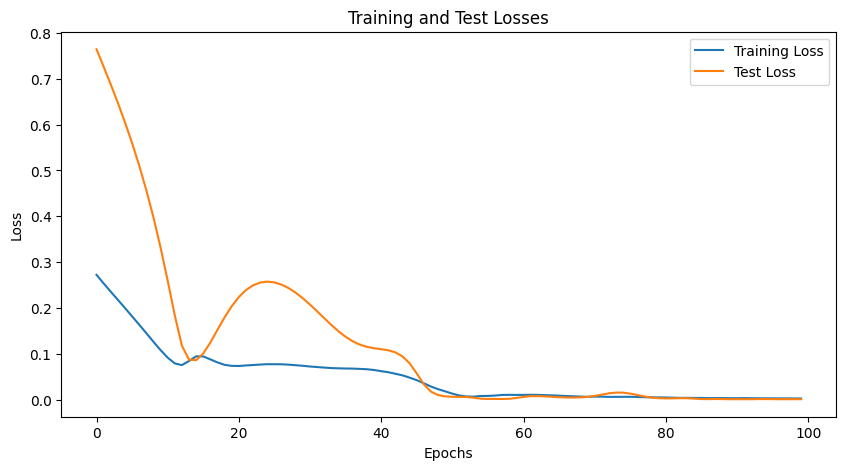

In [127]:
# Training loop
epochs = 100
batch_size = 32
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    train_loss = criterion(output.squeeze(), y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        test_loss = criterion(test_output.squeeze(), y_test)
        test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Training and Test Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Mean Squared Error (MSE): 3.5618
Mean Absolute Error (MAE): 1.5779
Mean Absolute Percentage Error (MAPE): 3.26%


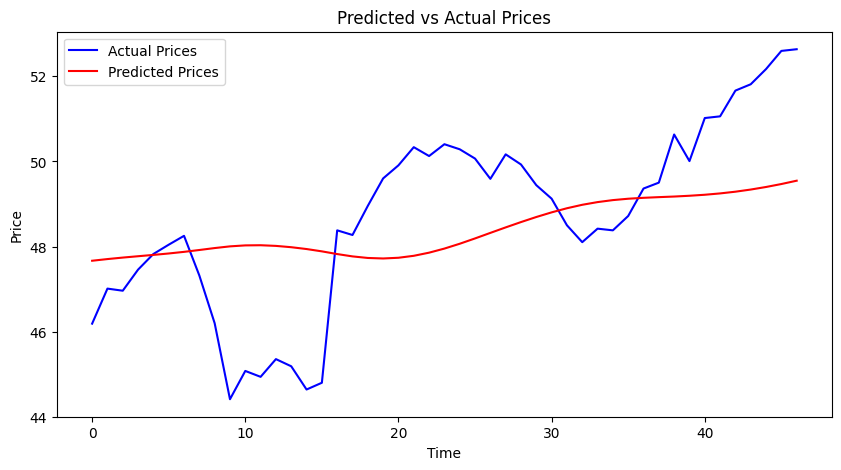

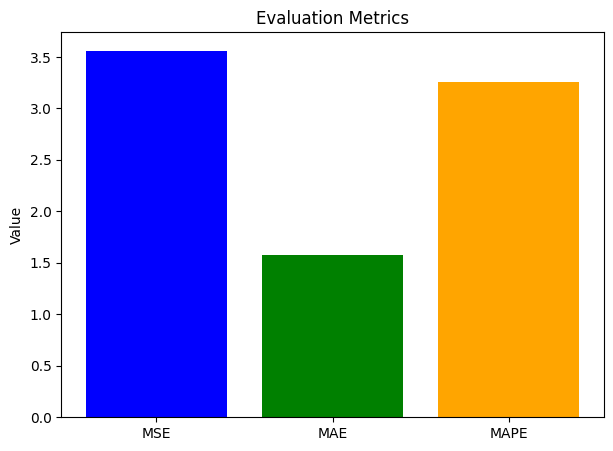

In [128]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predictions = scaler.inverse_transform(predictions.numpy().reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# Calculate metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot predictions vs actuals
plt.figure(figsize=(10, 5))
plt.plot(actuals, label="Actual Prices", color="blue")
plt.plot(predictions, label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot error metrics
metrics = {"MSE": mse, "MAE": mae, "MAPE": mape}
plt.figure(figsize=(7, 5))
plt.bar(metrics.keys(), metrics.values(), color=["blue", "green", "orange"])
plt.title("Evaluation Metrics")
plt.ylabel("Value")
plt.show()

## 2 Fitting the Model on Just Stock Data

In [69]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Split data into training (up to Sep 30, 2024) and testing (October 2024)
train_df = stock_data[stock_data['Date'] <= '2024-08-27']
test_df = stock_data[stock_data['Date'] > '2024-08-27']

# Extract features and labels
features = ['Open', 'High', 'Low', 'Volume']
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[features])
train_close = train_df['Close'].values

# Test data for ground truth comparison
test_close = test_df['Close'].values


In [70]:
# Function to create sequences
def create_sequences(data, targets, sequence_length=30):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(targets[i + sequence_length])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

# Create training sequences
sequence_length = 30
X_train, y_train = create_sequences(train_features, train_close, sequence_length)

In [71]:
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # Hidden state of last time step
        out = self.fc(h_n[-1])     # Output from the last layer's hidden state
        return out

# Model parameters
input_dim = len(features)
hidden_dim = 64
output_dim = 1
num_layers = 1

model = StockLSTM(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [60]:
# Train the model
epochs = 100
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


/Users/saad/Documents/UIC/Semester 1/Machine Learning/project/class-project-odin-s-sight/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4686])) that is different to the input size (torch.Size([4686, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/100, Loss: 892.3508911132812
Epoch 20/100, Loss: 878.7990112304688
Epoch 30/100, Loss: 833.354248046875
Epoch 40/100, Loss: 739.876953125
Epoch 50/100, Loss: 662.7769165039062
Epoch 60/100, Loss: 601.7880859375
Epoch 70/100, Loss: 553.3871459960938
Epoch 80/100, Loss: 514.7788696289062
Epoch 90/100, Loss: 482.4252014160156
Epoch 100/100, Loss: 454.5206298828125


In [75]:
# Predict October 2024 Close Prices
model.eval()
with torch.no_grad():
    # Use the last 30 days from training data as the initial input
    last_30_days = train_features[-30:]
    last_30_days = torch.tensor(last_30_days, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    predictions = []
    for _ in range(len(test_df)):
        # Predict the next day
        print(model(last_30_days))
        next_day = model(last_30_days).item()
        predictions.append(next_day)

        # Update the input: Remove the oldest and append the new prediction
        next_input = last_30_days[0, 1:].clone()  # Exclude the first day (shift)
        print(next_input)
        next_input = torch.cat((next_input, torch.tensor([[next_day]], dtype=torch.float32)), dim=0)
        last_30_days = next_input.unsqueeze(0)  # Update for the next iteration

# Compare predictions to ground truth
print("Predictions for October 2024 Close Prices:")
print(predictions)

tensor([[-0.0568]])
tensor([[ 1.5137,  1.5765,  1.5354, -0.3643],
        [ 1.5639,  1.5693,  1.5816, -0.6763],
        [ 1.5595,  1.5303,  1.5200, -0.6829],
        [ 1.5035,  1.4782,  1.4928, -0.6215],
        [ 1.4620,  1.4349,  1.4613, -0.7561],
        [ 1.4467,  1.4537,  1.4540, -0.4147],
        [ 1.5071,  1.5368,  1.5141, -0.5935],
        [ 1.5035,  1.5238,  1.5273, -0.7663],
        [ 1.5399,  1.5382,  1.5420, -0.9429],
        [ 1.5668,  1.5628,  1.5750, -0.6113],
        [ 1.5828,  1.5787,  1.6007, -0.6194],
        [ 1.5981,  1.5751,  1.5244, -0.6620],
        [ 1.5297,  1.5050,  1.4620, -0.4650],
        [ 1.4474,  1.4276,  1.3403, -0.2486],
        [ 1.3164,  1.3597,  1.3366, -0.5976],
        [ 1.3651,  1.3937,  1.3696, -0.6824],
        [ 1.3550,  1.3980,  1.3835, -0.6799],
        [ 1.3855,  1.3828,  1.3806, -0.5712],
        [ 1.3732,  1.3597,  1.3263, -0.6066],
        [ 1.3331,  1.3344,  1.3549, -0.5803],
        [ 1.3448,  1.3597,  1.3659, -0.2102],
        [ 1.60

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 4 but got size 1 for tensor number 1 in the list.

In [62]:
import numpy as np

# Evaluate the model
mse = np.mean((np.array(predictions) - test_close) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

mape = np.mean(np.abs((test_close - np.array(predictions)) / test_close)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

Mean Squared Error: nan
Mean Absolute Percentage Error: nan%


/Users/saad/Documents/UIC/Semester 1/Machine Learning/project/class-project-odin-s-sight/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saad/Documents/UIC/Semester 1/Machine Learning/project/class-project-odin-s-sight/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
